# MISCNN (Dense)

In [11]:
import miscnn
from miscnn.data_loading.interfaces.nifti_io import NIFTI_interface
from miscnn.data_loading.data_io import Data_IO
from miscnn.processing.subfunctions.normalization import Normalization
from miscnn.processing.subfunctions.clipping import Clipping
from miscnn.processing.subfunctions.resampling import Resampling
from miscnn.processing.data_augmentation import Data_Augmentation
from miscnn.processing.preprocessor import Preprocessor
from miscnn.neural_network.model import Neural_Network
from miscnn.neural_network.architecture.unet.dense import Architecture
from miscnn.neural_network.metrics import tversky_crossentropy, dice_soft, dice_crossentropy, tversky_loss
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, CSVLogger
from miscnn.evaluation.cross_validation import cross_validation

import requests
from tqdm import tqdm
import os
import zipfile
from IPython.display import Image

In [6]:
# Links to the data set
url_vol = "https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1"
url_seg = "https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1"

In [12]:
path_data = "test"

In [18]:
def download_from_url(url, dst):
    """
    @param: url to download file
    @param: dst place to put the file
    """
    file_size = int(requests.head(url).headers["Content-Length"])
    if os.path.exists(dst):
        first_byte = os.path.getsize(dst)
    else:
        first_byte = 0
    if first_byte >= file_size:
        print("WARNING: Skipping download due to files are already there.")
        return file_size
    header = {"Range": "bytes=%s-%s" % (first_byte, file_size)}
    pbar = tqdm(
        total=file_size, initial=first_byte,
        unit='B', unit_scale=True, desc=url.split('/')[-1])
    req = requests.get(url, headers=header, stream=True)
    with(open(dst, 'ab')) as f:
        for chunk in req.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                pbar.update(1024)
    pbar.close()
    return file_size

In [9]:
# Create data structure
if not os.path.exists(path_data) : os.makedirs(path_data)

In [10]:
# Download CT volumes and save them into the data directory
path_vol_zip = os.path.join(path_data, "volumes.zip")
print("INFO:", "Downloading Volumes")
download_from_url(url_vol, path_vol_zip)
# Download segmentations and save them into the data directory
path_seg_zip = os.path.join(path_data, "segmentations.zip")
print("INFO:", "Downloading Segmentations")
download_from_url(url_seg, path_seg_zip)

INFO: Downloading Volumes


COVID-19-CT-Seg_20cases.zip?download=1: 1.11GB [03:18, 5.57MB/s]                               


INFO: Downloading Segmentations


Lung_and_Infection_Mask.zip?download=1: 11.7MB [00:14, 784kB/s]                               


11714838

In [11]:
# Extract sample list from the ZIP file
print("INFO:", "Obtain sample list from the volumes ZIP file")
with zipfile.ZipFile(path_vol_zip, "r") as zip_vol:
    sample_list = zip_vol.namelist()

INFO: Obtain sample list from the volumes ZIP file


In [12]:
# Iterate over the sample list and extract each sample from the ZIP files
print("INFO:", "Extracting data from ZIP files")
for sample in tqdm(sample_list):
    # Skip if file does not end with nii.gz
    if not sample.endswith(".nii.gz") : continue
    # Create sample directory
    path_sample = os.path.join(path_data, sample[:-len(".nii.gz")])
    if not os.path.exists(path_sample) : os.makedirs(path_sample)
    # Extract volume and store file into the sample directory
    with zipfile.ZipFile(path_vol_zip, "r") as zip_vol:
        zip_vol.extract(sample, path_sample)
    os.rename(os.path.join(path_sample, sample),
              os.path.join(path_sample, "imaging.nii.gz"))
    # Extract segmentation and store file into the sample directory
    with zipfile.ZipFile(path_seg_zip, "r") as zip_seg:
        zip_seg.extract(sample, path_sample)
    os.rename(os.path.join(path_sample, sample),
              os.path.join(path_sample, "segmentation.nii.gz"))

  0%|          | 0/21 [00:00<?, ?it/s]

INFO: Extracting data from ZIP files


100%|██████████| 21/21 [00:12<00:00,  1.67it/s]


# Data I/O

In [13]:
## We are using 4 classes due to [background, lung_left, lung_right, covid-19]
interface = NIFTI_interface(channels=1, classes=4)

In [14]:
data_io = miscnn.Data_IO(interface, path_data)

# Pre-processor

In [15]:
# Create and configure the Data Augmentation class
data_aug = miscnn.Data_Augmentation(cycles=1, scaling=True, rotations=True,
                                    elastic_deform=True, mirror=True,
                                    brightness=True, contrast=True,
                                    gamma=True, gaussian_noise=True)

In [16]:
# Create a clipping Subfunction to the lung window of CTs (-1250 and 250)
sf_clipping = Clipping(min=-1250, max=250)
# Create a pixel value normalization Subfunction to scale between 0-255
sf_normalize = Normalization(mode="grayscale")
# Create a resampling Subfunction to voxel spacing 1.58 x 1.58 x 2.70
sf_resample = Resampling((1.58, 1.58, 2.70))
# Create a pixel value normalization Subfunction for z-score scaling
sf_zscore = Normalization(mode="z-score")

In [17]:
# Assemble Subfunction classes into a list
sf = [sf_clipping, sf_normalize, sf_resample, sf_zscore]

In [18]:
# Create and configure the Preprocessor class
pp = Preprocessor(data_io, data_aug=None, batch_size=2, subfunctions=sf,
                  prepare_subfunctions=True, prepare_batches=False,
                  analysis="patchwise-crop", patch_shape=(160, 160, 80))

In [19]:
# Adjust the patch overlap for predictions
pp.patchwise_overlap = (80, 80, 40)

# Neural Network Model

In [20]:
# Initialize the Architecture
unet_dense = Architecture(depth=4, activation="softmax",
                             batch_normalization=True)

In [22]:
unet_dense.summary()

AttributeError: 'Architecture' object has no attribute 'summary'

In [23]:
# Create the Neural Network model
model = Neural_Network(preprocessor=pp, architecture=unet_dense,
                       loss=tversky_crossentropy,
                       metrics=[tversky_loss, dice_soft, dice_crossentropy],
                       batch_queue_size=3, workers=3, learninig_rate=0.001)

In [46]:
# Create the Neural Network model
model = Neural_Network(preprocessor=pp, architecture=unet_dense,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'],
                       batch_queue_size=3, workers=3, learninig_rate=0.001)

In [28]:
model.summary()

AttributeError: 'Neural_Network' object has no attribute 'summary'

In [47]:
model.dump("my_model.hdf5")

In [48]:
from tensorflow import keras
model = keras.models.load_model('/Users/allarddejong/Downloads/Cross term project/my_model.hdf5')

In [49]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv3d_95 (Conv3D)              (None, None, None, N 896         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, None, None, N 128         conv3d_95[0][0]                  
__________________________________________________________________________________________________
concatenate_110 (Concatenate)   (None, None, None, N 0           input_6[0][0]                    
                                                                 batch_normalization_90[0][0

In [52]:
import netron

In [55]:
netron.start('/Users/allarddejong/Downloads/Cross term project/my_model.hdf5')


Stopping http://localhost:8080
Serving '/Users/allarddejong/Downloads/Cross term project/my_model.hdf5' at http://localhost:8080


In [35]:
sample_list = data_io.get_indiceslist()
sample_list.sort()

In [36]:
sample_list = sample_list[1:-2]

In [37]:
sample_list

['coronacases_001',
 'coronacases_002',
 'coronacases_003',
 'coronacases_004',
 'coronacases_005',
 'coronacases_006',
 'coronacases_007',
 'coronacases_008',
 'coronacases_009',
 'coronacases_010',
 'radiopaedia_10_85902_1',
 'radiopaedia_10_85902_3',
 'radiopaedia_14_85914_0',
 'radiopaedia_27_86410_0',
 'radiopaedia_29_86490_1',
 'radiopaedia_29_86491_1',
 'radiopaedia_36_86526_0',
 'radiopaedia_40_86625_0',
 'radiopaedia_4_85506_1',
 'radiopaedia_7_85703_0']

In [47]:
test = '/Users/allarddejong/Downloads/Cross term project/test/coronacases_001/imaging.nii.gz'

In [87]:
%matplotlib notebook
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel

<IPython.core.display.Javascript object>


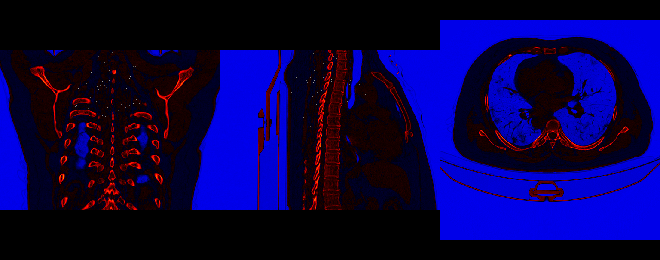

In [99]:
plotting.plot_stat_map(test, black_bg=True, draw_cross=False, annotate=False, colorbar=False)

<IPython.core.display.Javascript object>


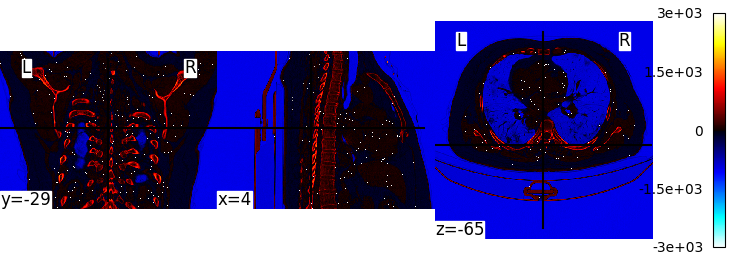

In [98]:
plotting.plot_stat_map(test)

In [6]:
# Load the image
img = cv2.imread("/Users/allarddejong/Downloads/grayscale.jpg")

In [7]:
noise_img = random_noise(img, mode='gaussian', seed=None, clip=True)

In [8]:
# Display the noise image
cv2.imshow('blur',noise_img)
cv2.waitKey(0)

0

In [5]:
image = '/Users/allarddejong/Downloads/Cross term project/greyscale.png'

In [ ]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

image = cv2.imread('/Users/allarddejong/Downloads/Cross term project/greyscale.png', cv2.IMREAD_GRAYSCALE)

new_img = elastic_transform(image, 2000, 40)

# Display the noise image
cv2.imshow('blur',new_img)
cv2.waitKey(0)

In [8]:
# Importing necessary functions 
from keras.preprocessing.image import ImageDataGenerator  
from keras.preprocessing.image import array_to_img, img_to_array, load_img 
# Initialising the ImageDataGenerator class. 
# We will pass in the augmentation parameters in the constructor. 
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        brightness_range = (0.5, 1.5)) 
    
# Loading a sample image  
img = load_img('/Users/allarddejong/Downloads/Cross term project/greyscale.png')  
# Converting the input sample image to an array 
x = img_to_array(img) 
# Reshaping the input image 
x = x.reshape((1, ) + x.shape)  
   
# Generating and saving 5 augmented samples  
# using the above defined parameters.  
i = 0
for batch in datagen.flow(x, batch_size = 1, 
                          save_to_dir ='preview',  
                          save_prefix ='image', save_format ='jpeg'): 
    i += 1
    if i > 5: 
        break

# Perform 3-fold cross validation

In [22]:
cb_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20, verbose=1, mode='min', min_delta=0.0001, cooldown=1,    
                          min_lr=0.00001)

In [25]:
# Run cross-validation function
cross_validation(sample_list, model, k_fold=2, epochs=1, iterations=150,
                 evaluation_path="evaluation", draw_figures=True, callbacks=[cb_lr])

KeyboardInterrupt: 

# Results

In [ ]:
#Image(filename = "evaluation/fold_0/validation.dice_soft.png")

In [ ]:
#Image(filename = "evaluation/fold_0/validation.loss.png")

In [ ]:
#Image(filename = "evaluation/fold_0/validation.dice_crossentropy.png")